In [4]:
%cd ..

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys


In [5]:
import os 
import sys
import pickle
import numpy as np
from spike.spike_analysis.spike_collection import SpikeCollection
import decodanda
import matplotlib.pyplot as plt
from decodanda import Decodanda, generate_synthetic_data, plot_perfs_null_model

In [6]:
rew_comp_spikes = SpikeCollection.load_collection(r"/blue/npadillacoreano/share/reward_comp_extention/Phy_rce2_rce3/spike_collection.json/spike_collection.json")

In [7]:
rew_comp_spikes.analyze(timebin = 100, ignore_freq = 0.5)

All set to analyze


In [8]:
#         >>> conditions = {
#         >>>     'outcome': ['win', 'lose'],
#         >>>     'competitiveness': ['high', 'low'']
#         >>> }
condition_dict = {'high_comp_win': ['high', 'win'],
                  'low_comp_win': ['low', 'win'],
                  'high_comp_lose': ['high', 'lose'],
                  'low_comp_lose': ['low', 'lose']}
def get_event_idx(rec, event, event_length, pre_window, timebin):
    events = rec.event_dict[event]
    pre_window = round(pre_window * 1000)
    event_length = event_length * 1000
    event_len = int((event_length + pre_window) / timebin)
    event_idx = np.zeros((events.shape[0],2))
    for i in range(events.shape[0]):
        pre_event = int((events[i][0] - pre_window) / timebin)
        post_event = pre_event + event_len
        event_idx[i] = [int(pre_event), int(post_event)]
    return(event_idx)

all_data_sets = []
for rec in rew_comp_spikes.recordings:


    include = True
    for event in ['high_comp_win', 'low_comp_win', 'high_comp_lose', 'low_comp_lose']:
        if len(rec.event_dict[event].shape) < 1:
            include = False
        # else:
        #     if rec.event_dict[event].shape[0] < 2:
        #         include = False 
            
    if include:
        outcome = np.full(rec.unit_firing_rate_array.shape[0], '', dtype='U10')  # Unicode string, max 10 chars
        competitiveness = np.full(rec.unit_firing_rate_array.shape[0], '', dtype='U10')

        trial = np.zeros(rec.unit_firing_rate_array.shape[0])
        time_from_onset = np.zeros(rec.unit_firing_rate_array.shape[0])
        for event in ['high_comp_win', 'low_comp_win', 'high_comp_lose', 'low_comp_lose']:
            outcome_val = condition_dict[event][1]
            comp_val = condition_dict[event][0]
            outcome_val = condition_dict[event][1]
            comp_val = condition_dict[event][0]
            event_idx = get_event_idx(rec, event, 10, 10, rec.timebin)
            i = 1
            for start_idx, end_idx in event_idx:
                if start_idx >0: 
                    outcome[int(start_idx):int(end_idx)] = outcome_val
                    competitiveness[int(start_idx):int(end_idx)] = comp_val 
                    trial[int(start_idx):int(end_idx)] = i
                    time_from_onset[int(start_idx):int(end_idx)] = np.arange(-10,10,rec.timebin/1000)
                    i +=1
            dataset = {}
        dataset['stimulus'] = outcome
        dataset['action'] = competitiveness
        dataset['trial'] = trial
        dataset['raster'] = rec.unit_firing_rate_array
        all_data_sets.append(dataset)
    
        

In [9]:
len(np.arange(-10,10,rec.timebin/1000))

200

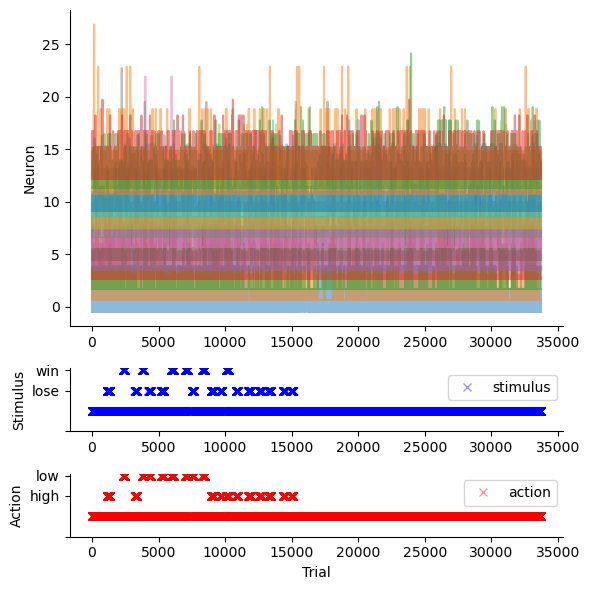

In [10]:
f, axs = plt.subplots(3, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [5, 1, 1]})
    
import seaborn as sns
stimulus = all_data_sets[0]['stimulus']
action = all_data_sets[0]['action']
raster = all_data_sets[0]['raster']
n_visualize = raster.shape[1]

for n in range(n_visualize):
  z_scored_x = (raster[:, n] - np.nanmean(raster[:, n])) / np.nanstd(raster[:, n])
  axs[0].plot(z_scored_x + n, alpha=0.5)
axs[0].set_ylabel('Neuron')

axs[1].plot(stimulus, label='stimulus', linewidth=4, alpha=0.4, linestyle='', marker='x', color='b')
axs[1].legend()
axs[1].set_ylabel('Stimulus')
axs[1].set_yticks([-1, 1, 2])

axs[2].plot(action, label='action', linewidth=4, alpha=0.4, linestyle='', marker='x', color='r')
axs[2].legend()
axs[2].set_xlabel('Trial')
axs[2].set_ylabel('Action')
axs[2].set_yticks([-1, 1, 2])


sns.despine(f)

In [11]:
from decodanda import Decodanda, generate_synthetic_data, plot_perfs_null_model
# Generating 4 data sets with low number of neurons (random between 5 and 10)

# Let's see how well they perform when decoded individually

# results = {}
# null_models = {}
# for i, dataset in enumerate(all_data_sets):
#     print('Decoding dataset #%u' % i)
#     res, null = Decodanda(data=dataset, conditions={'stimulus': ['win', 'lose'], 'action': ['high', 'low']}).decode(training_fraction=0.75)
#     results[i] = res['stimulus']
#     null_models[i] = null['stimulus']

# plot_perfs_null_model(results, null_models)
# plt.xlabel('Dataset #')
# plt.ylim([0.38, 1])

In [12]:
PSdec = Decodanda(data=all_data_sets, conditions={'stimulus': ['win', 'lose'], 'action': ['high', 'low']}, min_trials_per_condition=2, verbose = True)


		[Decodanda]	building conditioned rasters for session 0
			(stimulus = win, action = high):	Selected 200 time bin out of 33739, divided into 1 trials - 14 neurons
			(stimulus = win, action = low):	Selected 1000 time bin out of 33739, divided into 5 trials - 14 neurons
			(stimulus = lose, action = high):	Selected 2000 time bin out of 33739, divided into 10 trials - 14 neurons
			(stimulus = lose, action = low):	Selected 600 time bin out of 33739, divided into 3 trials - 14 neurons
			===> Session discarded for insufficient data.

		[Decodanda]	building conditioned rasters for session 1
			(stimulus = win, action = high):	Selected 3200 time bin out of 32309, divided into 16 trials - 6 neurons
			(stimulus = win, action = low):	Selected 200 time bin out of 32309, divided into 1 trials - 6 neurons
			(stimulus = lose, action = high):	Selected 200 time bin out of 32309, divided into 1 trials - 6 neurons
			(stimulus = lose, action = low):	Selected 200 time bin out of 32309, divided into 


Testing decoding performance for semantic dichotomy:  stimulus
[['10', '11'], ['00', '01']] 6000

[decode_dichotomy]	Decoding - 6000 time bins - 90 neurons - 8 brains
		(lose high) (lose low)
			vs.
		(win high) (win low)


  0%|          | 0/10 [00:00<?, ?it/s]


Looping over decoding cross validation folds:


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]



[decode_with_nullmodel]	 data <p> = 0.74

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]



Testing decoding performance for semantic dichotomy:  action
[['01', '11'], ['00', '10']] 6000

[decode_dichotomy]	Decoding - 6000 time bins - 90 neurons - 8 brains
		(win low) (lose low)
			vs.
		(win high) (lose high)


  0%|          | 0/10 [00:00<?, ?it/s]


Looping over decoding cross validation folds:


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]



[decode_with_nullmodel]	 data <p> = 0.48

[decode_with_nullmodel]	Looping over null model shuffles.


 80%|████████  | 8/10 [00:25<00:06,  3.16s/it]

Note: re-shuffling arrays


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]



Testing CCGP for semantic dichotomy:  stimulus

[decode_dichotomy]	Cross-condition decoding - 6000 time bins - 90 neurons - 8 brains
		(lose high) (lose low)
			vs.
		(win high) (win low)


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


		[CCGP_with_nullmodel]		----- Data: <p> = 0.75 -----



100%|██████████| 20/20 [00:08<00:00,  2.45it/s]



Testing CCGP for semantic dichotomy:  action

[decode_dichotomy]	Cross-condition decoding - 6000 time bins - 90 neurons - 8 brains
		(win low) (lose low)
			vs.
		(win high) (lose high)


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


		[CCGP_with_nullmodel]		----- Data: <p> = 0.49 -----



100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


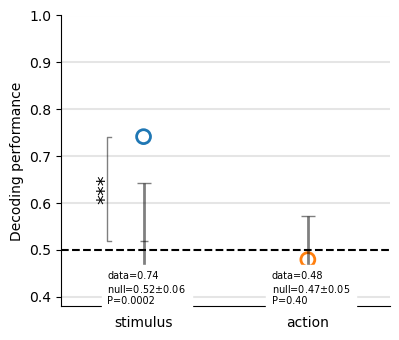

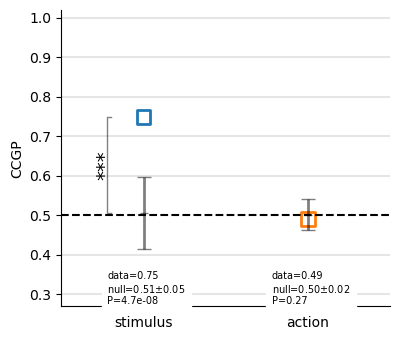

In [13]:
#                       ^list of dictionary

linear = PSdec.decode(training_fraction=0.75, plot = True)

plt.ylim([0.38, 1])

ccgp = PSdec.CCGP(nshuffles=20, plot=True)
#res, null = PSdec.CVI(training_fraction=0.75, nshuffles=20)
#_ = plot_perfs_null_model(res, null, ylabel='CVI', marker='$x$', color='g')

In [ ]:
#        Data structure
#         --------------
#         Decodanda works with datasets organized into Python dictionaries.
#         For ``N`` recorded neurons and ``T`` trials (or time bins), the data dictionary must contain:

#         1. a ``TxN`` array, under the ``raster`` key
#             This is the set of features we use to decode. Can be continuous (e.g., calcium fluorescence) or discrete (e.g., spikes) values.

#         2. a ``Tx1`` array specifying a ``trial`` number
#             This array will define the subdivisions for cross validation: trials (or time bins) that share the
#             same ```trial``` value will always go together in either training or testing samples.

#         3. a ``Tx1`` array for each variable we want to decode
#             Each value will be used as a label for the ``raster`` feature. Make sure these arrays are
#             synchronized with the ``raster`` array.


#         Say we have a data set with N=50 neurons, T=800 time bins divided into 80 trials, where two experimental
#         variables are specified ``stimulus`` and ``action``.
#         A properly-formatted data set would look like this:

#         >>> data = {
#         >>>     'raster': [[0, 1, ..., 0], ..., [0, 2, ..., 1]],     # <800x50 array>, neural activations
#         >>>     'stimulus': ['A', 'A', 'B', ..., 'B'],               # <800x1 array>, values of the stimulus variable
#         >>>     'action': ['left', 'left', 'none', ..., 'left'],    # <800x1 array>, values of the action variable
#         >>>     'trial':  [1, 1, 1, ..., 2, 2, 2, ..., 80, 80, 80],  # <800x1 array>, trial number, 80 unique numbers
#         >>> }

#         The ``conditions`` dictionary is used to specify which variables - out of
#         all the keywords in the ``data`` dictionary, and which and values - out of
#         all possible values of each specified variable - we want to decode.

#         It has to be in the form ``{key: [value1, value2]}``:

#         >>> conditions = {
#         >>>     'stimulus': ['A', 'B'],
#         >>>     'action': ['left', 'right']
#         >>> }

#         If more than one variable is specified, `Decodanda` will balance all
#         conditions during each decoding analysis to disentangle
#         the variables and avoid confounding correlations.

In [14]:
##import Optional
def CVI(dataset, training_fraction: float = 0.75,
            cross_validations: int = 10,
            nshuffles: int = 2,
            ndata: int = None,
            return_splits: bool = False,
            signed=False
            ):
#         if ndata is None:
#             ndata = 2 * dataset._max_conditioned_data

#         dics, vars = dataset._find_semantic_dichotomies()
#         print(dics, vars)
#         results = {}
#         for v1 in range(len(vars)):
#             var1 = vars[v1]
#             dic1 = dics[v1]
#             for v2 in range(len(vars)):
#                 if v2 != v1:
#                     var2 = vars[v2]
#                     dic2 = dics[v2]
#                     results[f'{var1}-{var2}'] = []
#                     for k in range(cross_validations):
#                         perf = dataset._one_X_cv_step(dic1, dic2, training_fraction, ndata)
#                         results[f'{var1}-{var2}'].append(perf)
#                     if signed:
#                         results[f'{var1}-{var2}'] = np.nanmean(np.asarray(results[f'{var1}-{var2}']))
#                     else:
#                         results[f'{var1}-{var2}'] = 0.5 + np.abs(
#                             np.nanmean(np.asarray(results[f'{var1}-{var2}']) - 0.5))
#         print(results)
#        null = {key: [] for key in results}
        for n in range(nshuffles):
            _shuffle_conditioned_arrays(dataset, dic = 'XOR')
        #     for v1 in range(len(vars)):
        #         var1 = vars[v1]
        #         dic1 = dics[v1]
        #         for v2 in range(len(vars)):
        #             if v2 != v1:
        #                 var2 = vars[v2]
        #                 dic2 = dics[v2]
        #                 null_n = []
        #                 for k in range(cross_validations):
        #                     perf = dataset._one_X_cv_step(dic1, dic2, training_fraction, ndata)
        #                     null_n.append(perf)
        #                 null[f'{var1}-{var2}'].append(np.nanmean(null_n))
        #     dataset._order_conditioned_rasters()
        #     print(null)
        # if not return_splits:
        #     megakey = '-'.join(vars)
        #     results_combined = {megakey: np.nanmean([results[key] for key in results])}
        #     null_combined = {megakey: [np.nanmean([null[key][i] for key in null]) for i in range(nshuffles)]}
        #     return results_combined, null_combined
        # return results, null
        
def _shuffle_conditioned_arrays(data, dic='XOR'):
        """
        the null model is built by interchanging trials between conditioned arrays that are in different
        dichotomies but have only hamming distance = 1. This ensures that even in the null model the other
        conditions (i.e., the one that do not define the dichotomy), are balanced during sampling.
        So if my dichotomy is [1A, 1B] vs [0A, 0B], I will change trials between 1A and 0A, so that,
        with oversampling, I will then ensure balance between A and B.
        If the dichotomy is not semantic, then I'll probably have to interchange between conditions regardless
        (to be implemented).

        :param dic: The dichotomy to be decoded
        """
        # if the dichotomy is semantic, shuffle between rasters at semantic distance=1
        if data._dic_key(dic):
            print('hello')
            set_A = dic[0]
            set_B = dic[1]
            
#             for i in range(len(set_A)):
#                 for j in range(len(set_B)):
#                     test_condition_A = set_A[i]
#                     test_condition_B = set_B[j]
#                     if hamming(string_bool(test_condition_A), string_bool(test_condition_B)) == 1:
#                         for n in range(data.n_brains):
#                             # select conditioned rasters
#                             arrayA = np.copy(data.conditioned_rasters[test_condition_A][n])
#                             arrayB = np.copy(data.conditioned_rasters[test_condition_B][n])

#                             # select conditioned trial index
#                             trialA = np.copy(data.conditioned_trial_index[test_condition_A][n])
#                             trialB = np.copy(data.conditioned_trial_index[test_condition_B][n])

#                             n_trials_A = len(np.unique(trialA))
#                             n_trials_B = len(np.unique(trialB))

#                             # assign randomly trials between the two conditioned rasters, keeping the same
#                             # number of trials between the two conditions

#                             all_rasters = []
#                             all_trials = []

#                             for index in np.unique(trialA):
#                                 all_rasters.append(arrayA[trialA == index, :])
#                                 all_trials.append(trialA[trialA == index])

#                             for index in np.unique(trialB):
#                                 all_rasters.append(arrayB[trialB == index, :])
#                                 all_trials.append(trialB[trialB == index])

#                             all_trial_index = np.arange(n_trials_A + n_trials_B).astype(int)
#                             np.random.shuffle(all_trial_index)

#                             new_rasters_A = [all_rasters[iA] for iA in all_trial_index[:n_trials_A]]
#                             new_rasters_B = [all_rasters[iB] for iB in all_trial_index[n_trials_A:]]

#                             new_trials_A = [all_trials[iA] for iA in all_trial_index[:n_trials_A]]
#                             new_trials_B = [all_trials[iB] for iB in all_trial_index[n_trials_A:]]

#                             data.conditioned_rasters[test_condition_A][n] = np.vstack(new_rasters_A)
#                             data.conditioned_rasters[test_condition_B][n] = np.vstack(new_rasters_B)

#                             data.conditioned_trial_index[test_condition_A][n] = np.hstack(new_trials_A)
#                             data.conditioned_trial_index[test_condition_B][n] = np.hstack(new_trials_B)
        else:
            print('woo')
            print(data.n_brains)
            for n in range(data.n_brains):
                # select conditioned rasters
                for iteration in range(10):
                    all_conditions = list(data._semantic_vectors.keys())
                    all_data = np.vstack([data.conditioned_rasters[cond][n] for cond in all_conditions])
                    all_trials = np.hstack([data.conditioned_trial_index[cond][n] for cond in all_conditions])
                    all_n_trials = {cond: len(np.unique(data.conditioned_trial_index[cond][n])) for cond in
                                    all_conditions}
                    print('all_n_trials', all_n_trials)

                    unique_trials = np.unique(all_trials)
                    np.random.shuffle(unique_trials)
                    
                    i = 0
                    for cond in all_conditions:
                        cond_trials = unique_trials[i:i + all_n_trials[cond]]
                        print(cond, len(cond_trials), n)
                        new_cond_array = []
                        new_cond_trial = []
                        for trial in cond_trials:
                            new_cond_array.append(all_data[all_trials == trial])
                            new_cond_trial.append(all_trials[all_trials == trial])
                        print(len(new_cond_array))
                        # data.conditioned_rasters[cond][n] = np.vstack(new_cond_array)
                        # data.conditioned_trial_index[cond][n] = np.hstack(new_cond_trial)
                        i += all_n_trials[cond]

        if not data._check_trial_availability():  # if the trial distribution is not cross validatable, redo the shuffling
            print("Note: re-shuffling arrays")
            data._order_conditioned_rasters()
            data._shuffle_conditioned_arrays(dic)


    
PSdec = Decodanda(data=all_data_sets, conditions={'stimulus': ['win', 'lose'], 'action': ['high', 'low']}, verbose = False)

lowdim_data = generate_synthetic_data(n_neurons=100, n_trials=80, keyA='position', keyB='identity', mixed_term=0.0)
conditions = {
    'position': [-1, 1],
    'identity': [-1, 1]
}
lowd_dec = Decodanda(data=lowdim_data, conditions=conditions, verbose=False, zscore=True)
CVI(lowd_dec)
CVI(PSdec)




woo
1
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
all_n_trials {'00': 18, '01': 23, '10': 20, '11': 19}
00 18 0
18
01 23 0
23
10 20 0
20
11 19 0
19
woo
1
all_n_tr

In [ ]:

for cond, data in PSdec.conditioned_rasters.items():
    print(cond)
    for brain in data:
        print(brain.shape)

In [82]:
PSdec.all_dichotomies(balanced=True, semantic_names=False)

{'stimulus': [['10', '11'], ['00', '01']],
 'action': [['01', '11'], ['00', '10']],
 '01_10_v_00_11': [['01', '10'], ['00', '11']]}

In [90]:
PSdec._dic_key('XOR')

0